In [1]:
import math
import time

import numba
import numpy as np
import matplotlib.pyplot as plt
import scipy

from numba import njit, prange
from stumpy import core

In [15]:
def _list7_fft_v0(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            for q in range(s):
                y[q] = x[q]
    else:
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            for q in range(s):
                a = complex(x[q + s*(p + 0)])
                b = complex(x[q + s*(p + m)])
                y[q + s*(2*p + 0)] = a + b
                y[q + s*(2*p + 1)] = (a - b) * wp
        _list7_fft_v0(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v0(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v0(n, 1, False, x, y)
    
    

def list7_ifft_v0(x):
    """
    where x is the fft result
    """
    n = len(x) 
    x = np.conjugate(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v0(n, 1, False, x, y)
    
    return np.conjugate(x / n)


def _list7_sliding_dot_product_v0(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    list7_fft_v0(x)
    list7_fft_v0(Qr)
    Qr[:] = list7_ifft_v0(x * Qr)
    
    return Qr.real[m-1:]


def sliding_dot_product_v0(Q, T):
    return _list7_sliding_dot_product(Q, T)

In [16]:
T = np.arange(8).astype(np.float64)
Q = np.arange(3).astype(np.float64)

print('Q: ', Q)
print('T: ', T)
print('------------------------------')

ref_QT = core.sliding_dot_product(Q, T)
print('ref_QT: ', ref_QT)

comp_QT = sliding_dot_product_v0(Q, T)
print('comp_QT: ', comp_QT)

np.testing.assert_almost_equal(ref_QT, comp_QT)

Q:  [0. 1. 2.]
T:  [0. 1. 2. 3. 4. 5. 6. 7.]
------------------------------
ref_QT:  [ 5.  8. 11. 14. 17. 20.]
comp_QT:  [ 5.  8. 11. 14. 17. 20.]


In [46]:
n = 2 ** 13
m_values = range(10, 1001, 10)

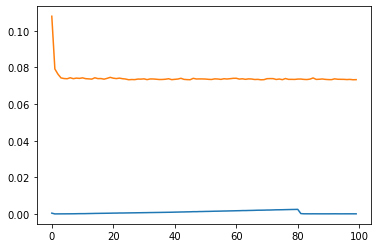

In [48]:
comp_func = sliding_dot_product_v0
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

n = 2 ** 13
T = np.random.rand(n)

running_time = np.zeros((len(m_values), 2)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp
    t1 = time.time()
    comp = comp_func(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    np.testing.assert_almost_equal(ref, comp)
    

plt.plot(running_time[:, 0], label='ref')
plt.plot(running_time[:, 1], label='comp')
plt.show()

In [49]:
# let's improve the function
def _list7_fft_v1(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            for q in range(s):
                y[q] = x[q]
    else:
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            for q in range(s):
                a = complex(x[q + s*(p + 0)])
                b = complex(x[q + s*(p + m)])
                y[q + s*(2*p + 0)] = a + b
                y[q + s*(2*p + 1)] = (a - b) * wp
        _list7_fft_v1(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v1(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v1(n, 1, False, x, y)
    

    
def _list7_ifft_v1(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v1(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v1(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v1(n, x, y)

def _list7_sliding_dot_product_v1(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    y = np.empty(n, dtype=complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v1(n, 1, False, x, y)
    _list7_fft_v1(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v1(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v1(Q, T):
    return _list7_sliding_dot_product_v1(Q, T)

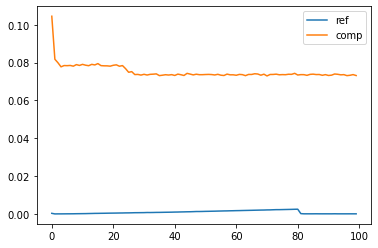

In [50]:
comp_func = sliding_dot_product_v1
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

T = np.random.rand(n)

running_time = np.zeros((len(m_values), 2)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp
    t1 = time.time()
    comp = comp_func(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    np.testing.assert_almost_equal(ref, comp)
    

plt.plot(running_time[:, 0], label='ref')
plt.plot(running_time[:, 1], label='comp')
plt.legend()
plt.show()

In [51]:
# let's improve the function
def _list7_fft_v2(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v2(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v2(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v2(n, 1, False, x, y)
    

    
def _list7_ifft_v2(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v2(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v2(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v2(n, x, y)

def _list7_sliding_dot_product_v2(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    y = np.empty(n, dtype=complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v2(n, 1, False, x, y)
    _list7_fft_v2(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v2(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v2(Q, T):
    return _list7_sliding_dot_product_v2(Q, T)

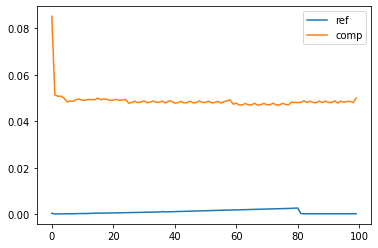

In [52]:
comp_func = sliding_dot_product_v2
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

T = np.random.rand(n)

running_time = np.zeros((len(m_values), 2)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp
    t1 = time.time()
    comp = comp_func(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    np.testing.assert_almost_equal(ref, comp)
    

plt.plot(running_time[:, 0], label='ref')
plt.plot(running_time[:, 1], label='comp')
plt.legend()
plt.show()

In [53]:
# let's improve the function
@njit(fastmath=True)
def _list7_fft_v3(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v3(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v3(x):
    n = len(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v3(n, 1, False, x, y)
    

@njit(fastmath=True)
def _list7_ifft_v3(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v3(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v3(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v3(n, x, y)

@njit(fastmath=True)
def _list7_sliding_dot_product_v3(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(np.complex128)
    y = np.empty(n, dtype=np.complex128)
    Qr = np.zeros(n, dtype=np.complex128)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v3(n, 1, False, x, y)
    _list7_fft_v3(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v3(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v3(Q, T):
    return _list7_sliding_dot_product_v3(Q, T)

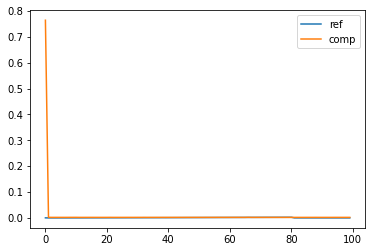

In [54]:
comp_func = sliding_dot_product_v3
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

T = np.random.rand(n)

running_time = np.zeros((len(m_values), 2)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp
    t1 = time.time()
    comp = comp_func(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    np.testing.assert_almost_equal(ref, comp)
    

plt.plot(running_time[:, 0], label='ref')
plt.plot(running_time[:, 1], label='comp')
plt.legend()
plt.show()

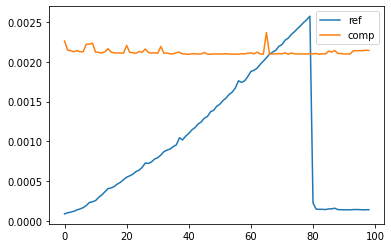

In [55]:
plt.plot(running_time[1:, 0], label='ref')
plt.plot(running_time[1:, 1], label='comp')
plt.legend()
plt.show()

In [57]:
# let's improve the function
@njit(fastmath=True, parallel=True)
def _list7_fft_v4(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in prange(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v4(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v4(x):
    n = len(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v4(n, 1, False, x, y)
    

@njit(fastmath=True)
def _list7_ifft_v4(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v4(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v4(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v4(n, x, y)

@njit(fastmath=True)
def _list7_sliding_dot_product_v4(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(np.complex128)
    y = np.empty(n, dtype=np.complex128)
    Qr = np.zeros(n, dtype=np.complex128)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v4(n, 1, False, x, y)
    _list7_fft_v4(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v4(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v4(Q, T):
    return _list7_sliding_dot_product_v4(Q, T)

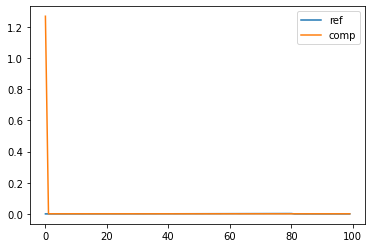

In [58]:
comp_func = sliding_dot_product_v4
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

T = np.random.rand(n)

running_time = np.zeros((len(m_values), 2)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp
    t1 = time.time()
    comp = comp_func(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    np.testing.assert_almost_equal(ref, comp)
    

plt.plot(running_time[:, 0], label='ref')
plt.plot(running_time[:, 1], label='comp')
plt.legend()
plt.show()

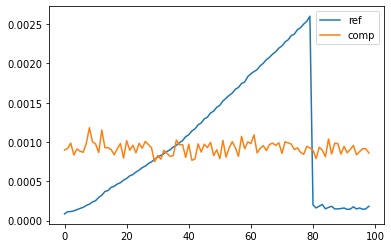

In [59]:
plt.plot(running_time[1:, 0], label='ref')
plt.plot(running_time[1:, 1], label='comp')
plt.legend()
plt.show()

In [62]:
2 ** 20

1048576

In [122]:
n_T = np.power(2, range(11, 21))

In [123]:
comp_func = sliding_dot_product_v4
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

out = {}
m_values = range(10, 1010, 10)
for p in range(10, 21):
    # print('--------------------------')
    # print(f'p --> {p}')
    
    n = 2 ** p
    T = np.random.rand(n)
    
    running_time = np.zeros((len(m_values), 2))         
    for i, m in enumerate(m_values):
        # print(f'm={m}')
        Q = T[:m]

        # ref
        t1 = time.time()
        ref = ref_func(Q, T)
        t2 = time.time()
        running_time[i, 0] = t2 - t1

        # comp
        t1 = time.time()
        comp = comp_func(Q, T)
        t2 = time.time()
        running_time[i, 1] = t2 - t1

        np.testing.assert_almost_equal(ref, comp)
    
    out[p] = running_time

In [124]:
out.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [125]:
colors=['k', 'r', 'b', 'gray', 'orange', 'darkgreen', 'darkgreen', 'cyan', 'gray', 'purple', 'brown']

In [126]:
m_values_arr = np.arange(0, 1000, 100)
m_values_arr[0] = 10
m_values_arr = np.append(m_values_arr, 1000)
IDX = np.flatnonzero(np.isin(m_values, m_values_arr))

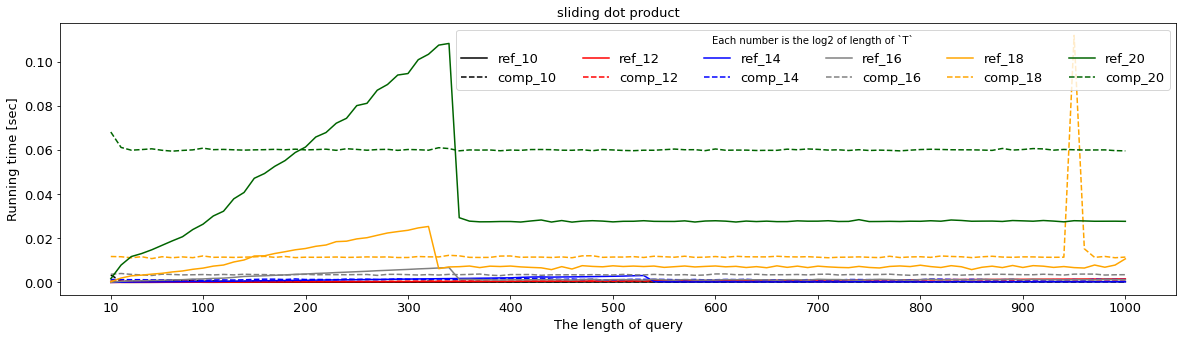

In [127]:

plt.figure(figsize=(20, 5))
plt.title('sliding dot product', fontsize=13)
for i, p in enumerate([10, 12, 14, 16, 18, 20]):  # enumerate(list(out.keys())):
    plt.plot(out[p][:, 0], c=colors[i], label=f'ref_{p}')
    plt.plot(out[p][:, 1], c=colors[i], linestyle='--', label=f'comp_{p}')

    
plt.xticks(ticks=IDX, labels=m_values_arr, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('The length of query', fontsize=13)
plt.ylabel('Running time [sec]', fontsize=13)
plt.legend(title='Each number is the log2 of length of `T`', ncols=6, fontsize=13)
plt.show()